# HW8: Object Detection

In this exercise we will implement a couple of modern object detection methods:
1. Viola-Jones fast face detection with binary features and adaptive boosting
1. Object detector based on Fast RCNN and a convolutional neural network

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tqdm # progress bar
import requests, zipfile, io, os, glob, json
from PIL import Image
import tensorflow as tf

## Face Detection with Viola-Jones

We're going to create our very own Viola-Jones-ish **face detector** with Haar-like binary features and an **AdaBoost classifier based on 1-level Decision Trees** (basically a single split based on a single feature).

The seminal work from Paul Viola and Michael: https://ieeexplore.ieee.org/abstract/document/990517?casa_token=iX_J6XdXCpkAAAAA:hkye1lah3VES2-NlXn9LJIASXmluCobfifdW2gUK4dlDWTUtgzL9JWJsl3P4bBt2pBrzVQ4



Load the data: (based on the [FDDB](http://vis-www.cs.umass.edu/fddb/))

In [261]:
id = '1SLI12ggbnM_f9ZfZa0Bed-1GYwzuMOvV'
dl_url = f'https://drive.google.com/uc?id={id}&export=download&confirm=t'

if not os.path.exists('faces_db.npz'):
    # download and show progress bar
    print('Downloading faces_db.npz...')
    with open('faces_db.npz', 'wb') as f:
        request = requests.get(dl_url, stream=True)
        total_length = int(request.headers.get('content-length'))
        for chunk in tqdm.tqdm(request.iter_content(chunk_size=1024), total=total_length/1024, unit='KB'):
            if chunk:
                f.write(chunk)
                f.flush()

data = np.load('faces_db.npz')
faces = data['faces']
not_faces = data['not_faces']

### Faces

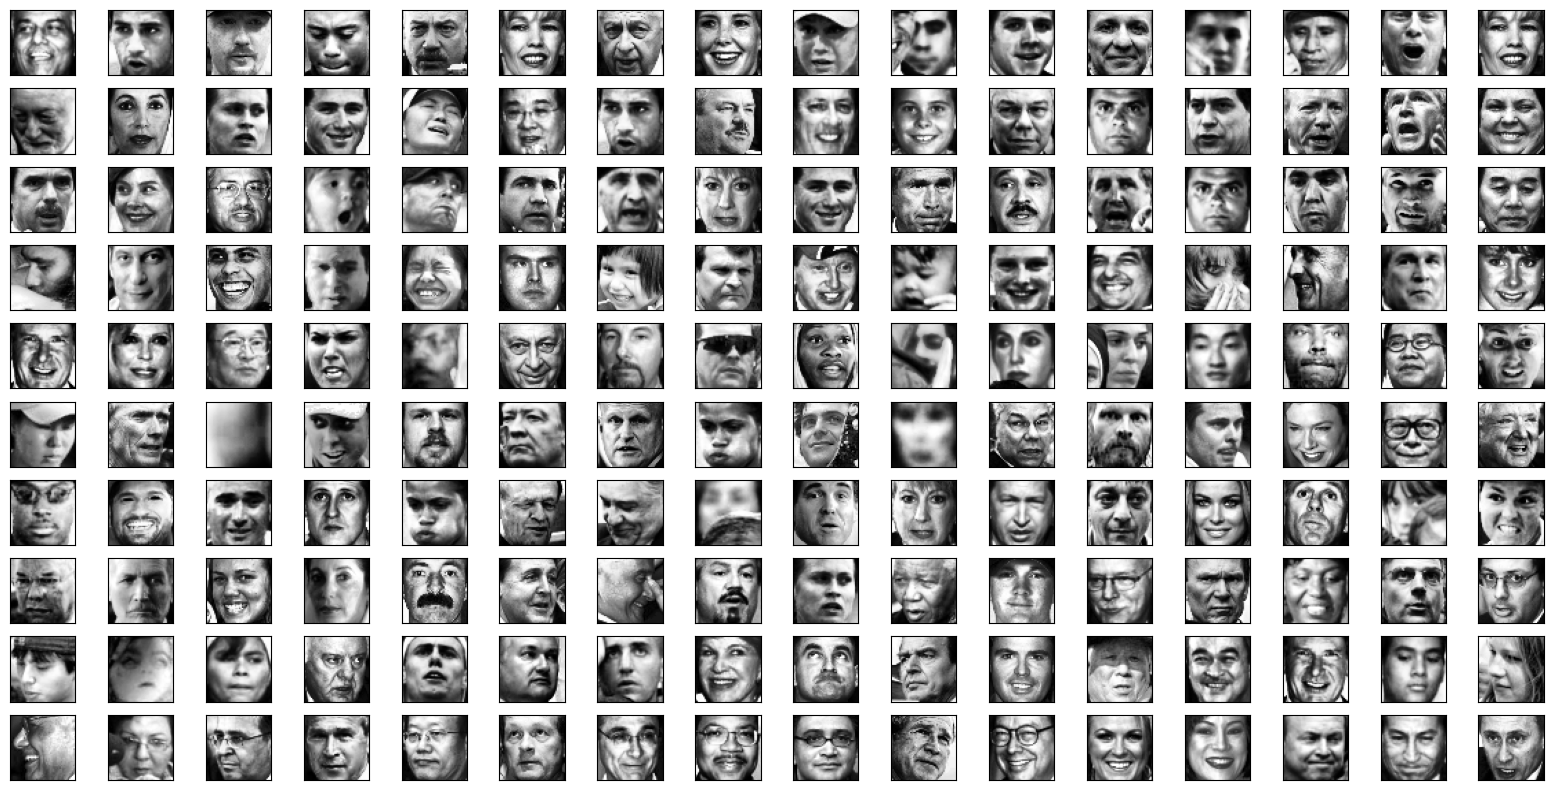

In [262]:
plt.figure(figsize=(20,10))
for i in range(160):
    plt.subplot(10,16,i+1)
    plt.imshow(faces[np.random.randint(0,len(faces))], cmap='gray')
    plt.xticks([]),plt.yticks([])

### Not Faces

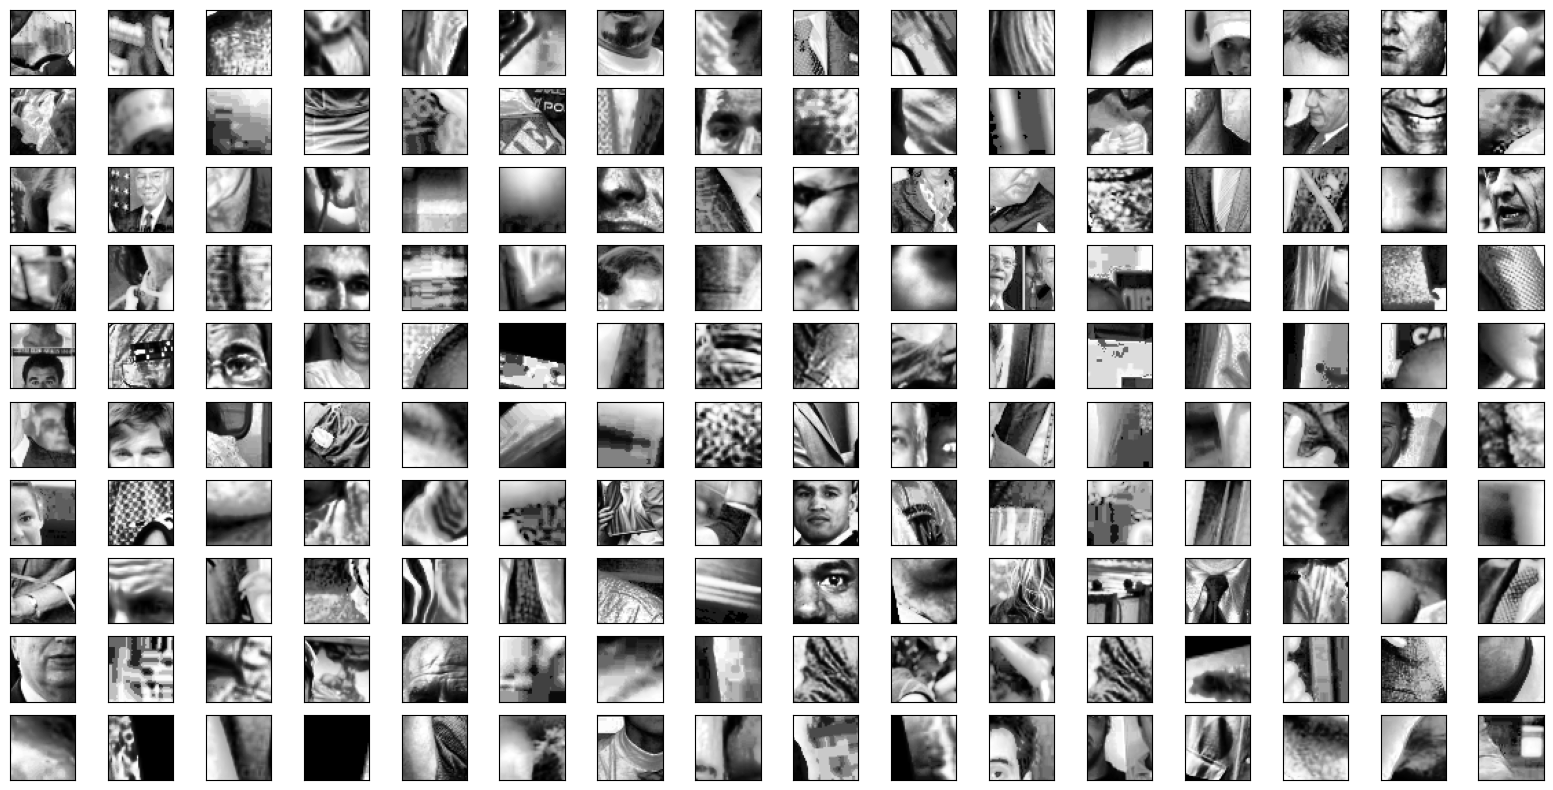

In [263]:
plt.figure(figsize=(20,10))
for i in range(160):
    plt.subplot(10,16,i+1)
    plt.imshow(not_faces[np.random.randint(0,len(not_faces))], cmap='gray')
    plt.xticks([]),plt.yticks([])

Put all samples (positive + negative) in a single array and create a binary annotation {0,1}:

In [264]:
X_faces = np.vstack([faces, not_faces])
y_faces = np.array([1] * len(faces) + [0] * len(not_faces))

### Create Haar-like binary features

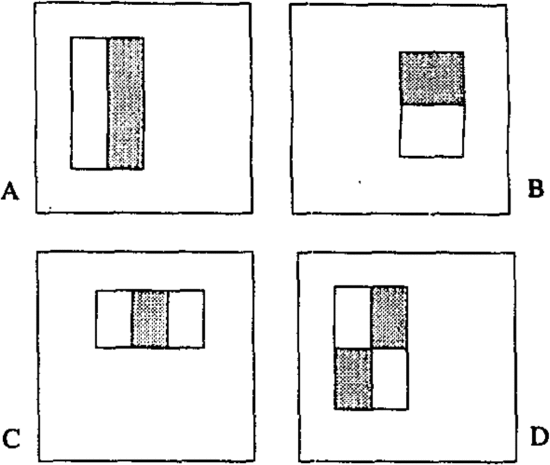

Randomize 1000 Haar-like binary features:
1. Randomize width & height (range [min,max] = [10,30])
1. Randomize feature type: horizontal/vertical + 2-split/3-split (total 4 types)
1. Randomize x,y (make sure not exceed image bounds)

Here's a function to draw the features, and below is where you will build the featuers.

In [265]:
# util function to draw a Haar-like feature
def draw_haar_feature(im, haar_feature):
    x,y,w,h,ft = haar_feature
    x1,y1 = x + w, y + h
    xmid,ymid = int(x+w/2.),  int(y+h/2.)
    x13,y13   = int(x+w/3.),  int(y+h/3.)
    x23,y23   = int(x+2*w/3.),int(y+2*h/3.)
    assert(ft < 4 and ft >= 0)

    if ft == 0:
        cv2.rectangle(im, (x,y),    (x1,ymid), (0,255,0), cv2.FILLED)
        cv2.rectangle(im, (x,ymid), (x1,y1), (255,0,0), 1)
    if ft == 1:
        cv2.rectangle(im, (x,y),    (xmid,y1), (0,255,0), cv2.FILLED)
        cv2.rectangle(im, (xmid,y), (x1,y1), (255,0,0), 1)
    if ft == 2:
        cv2.rectangle(im, (x,y),   (x1,y13), (255,0,0), 1)
        cv2.rectangle(im, (x,y13), (x1,y23), (0,255,0), cv2.FILLED)
        cv2.rectangle(im, (x,y23), (x1,y1), (255,0,0), 1)
    if ft == 3:
        cv2.rectangle(im, (x,y),   (x13,y1), (255,0,0), 1)
        cv2.rectangle(im, (x13,y), (x23,y1), (0,255,0), cv2.FILLED)
        cv2.rectangle(im, (x23,y), (x1,y1), (255,0,0), 1)
    return im

In [266]:
NUM_HAAR_FEATURES = 1000

Randomize the feature types (1,2,3 or 4) and coordinates and save them in the `haar_features` list. The images we work with are $48 \times 48$ so the coordinates of the features should be bounded by these limits.

In [267]:
haar_features = []
# TODO: populate haar_features with random Haar-like features (x,y,w,h,type)

for i in range(NUM_HAAR_FEATURES):
    w = np.random.randint(10, 30)
    h = np.random.randint(10, 30)
    x = np.random.randint(0, 48-w)
    y = np.random.randint(0, 48-h)
    
    ft = np.random.randint(0, 4)
    haar_features.append([x, y, w, h, ft])

    

Visualize the first 45 features:

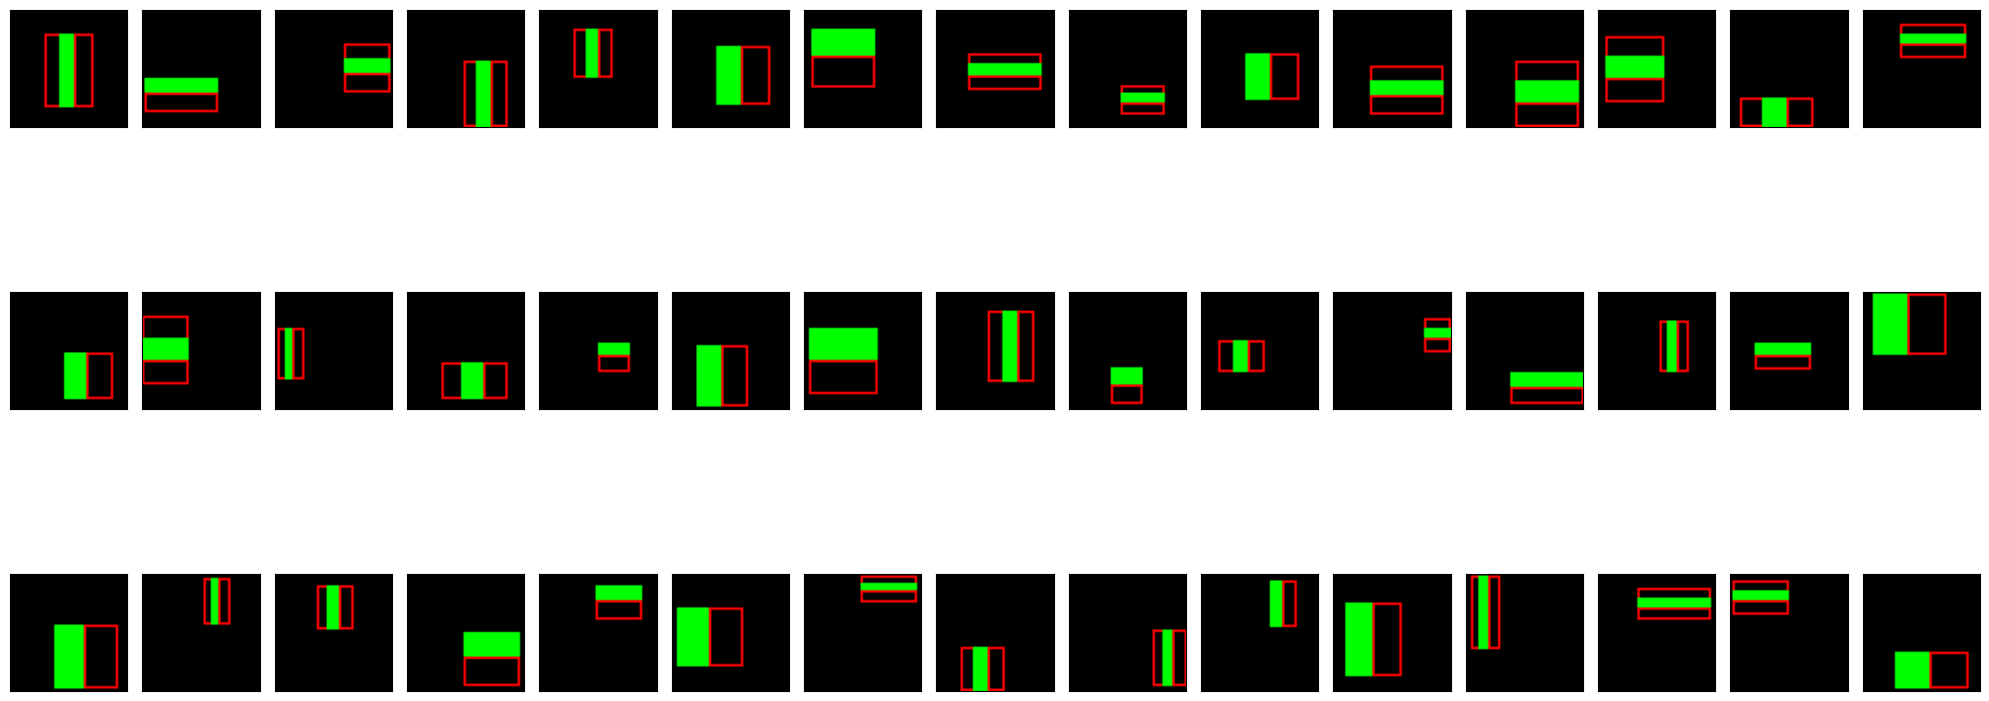

In [268]:
plt.figure(figsize=(20,10))
haar_features_im = np.zeros((48,48,3),np.uint8)
for i in range(45):
    plt.subplot(3,15,i+1)
    plt.imshow(draw_haar_feature(haar_features_im.copy(), haar_features[i]))
    plt.xticks([]),plt.yticks([])
plt.tight_layout()

### Calculate responses
Calculate the feature responses for all samples, using the integral image.
Create a dataset of shape: (\[num_samples\], 1000)

You may want to implement a helper function that does the summation over the integral image, like the paper suggests:
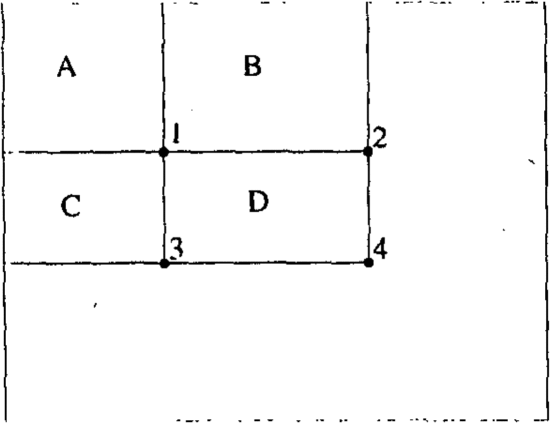

"The sum of the pixels within rectangle D can be computed with four array references. The value of the integral image at location 1 is the sum of the pixels in rectangle A, The value at location 2 is A+B, at location 3 is A+C, and at location 4 is A+B+C+D. The sum within D can be computed as 4 + 1 - (2 + 3)."

Note that the different feature types will have a different number of summations.

In [269]:
# TODO: extract Haar-like features from an image
# ii is the integral image of the image, if provided it will be used
# otherwise it will be computed.
# the function returns a list of feature responses (one number for each feature)
def extract_haar_features_responses(imgray, haar_features_, ii=None):
    # Compute integral image if not provided
    if ii is None:
        ii = cv2.integral(imgray)

    responses = []
    for x, y, w, h, ft in haar_features_:
        # Feature type 0
        if ft == 0:
            top = ii[y + h//2, x + w] - ii[y, x + w] - ii[y + h//2, x] + ii[y, x]
            bottom = ii[y + h, x + w] - ii[y + h//2, x + w] - ii[y + h, x] + ii[y + h//2, x]
            response = top - bottom

        # Feature type 1
        elif ft == 1:
            left = ii[y + h, x + w//2] - ii[y, x + w//2] - ii[y + h, x] + ii[y, x]
            right = ii[y + h, x + w] - ii[y, x + w] - ii[y + h, x + w//2] + ii[y, x + w//2]
            response = left - right

        # Feature type 2
        elif ft == 2:
            top = ii[y + h//3, x + w] - ii[y, x + w] - ii[y + h//3, x] + ii[y, x]
            middle = ii[y + 2*h//3, x + w] - ii[y + h//3, x + w] - ii[y + 2*h//3, x] + ii[y + h//3, x]
            bottom = ii[y + h, x + w] - ii[y + 2*h//3, x + w] - ii[y + h, x] + ii[y + 2*h//3, x]
            response = top - middle + bottom

        # Feature type 3
        elif ft == 3:
            left = ii[y + h, x + w//3] - ii[y, x + w//3] - ii[y + h, x] + ii[y, x]
            middle = ii[y + h, x + 2*w//3] - ii[y, x + 2*w//3] - ii[y + h, x + w//3] + ii[y, x + w//3]
            right = ii[y + h, x + w] - ii[y, x + w] - ii[y + h, x + 2*w//3] + ii[y, x + 2*w//3]
            response = left - middle + right

        else:
            raise ValueError("Invalid feature type")

        responses.append(response)

    return responses


Since extracting the responses from 1000s of images is a lengthy operation I've added a progress bar:

In [270]:
X_faces_features = []
for i in tqdm.tqdm(range(len(X_faces))):
    X_faces_features.append(extract_haar_features_responses(X_faces[i], haar_features))

  1%|          | 46/8416 [00:00<00:18, 456.28it/s]0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
100%|██████████| 8416/8416 [00:17<00:00, 487.34it/s]


Shuffle and split the dataset to training and testing using `sklearn.model_selection`'s `train_test_split`

Use `X_train, X_test, y_train, y_test`

In [271]:
# TODO: X_train, X_test, y_train, y_test = ...
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_faces_features, y_faces, test_size=0.2)

### Create and train an Adaptive Boosting classifier

Define an AdaBoost classifier (`AdaBoostClassifier` from `sklearn.ensemble`) with just 20 estimators (each estimator is a depth-1 decision tree which is `DecisionTreeClassifier` from `sklearn.tree`).

Create the decision tree with `max_depth=1` and the AdaBoost classifier with `n_estimators=20`.

Name the classifier `bdt` (boosted decision trees)

Train the model on the training data (`X_train` and `y_train`)

In [272]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Create a decision tree classifier with max_depth=1
base_estimator = DecisionTreeClassifier(max_depth=1)

# Create the AdaBoost classifier with 20 estimators
bdt = AdaBoostClassifier(estimator=base_estimator, n_estimators=20)

# Train the AdaBoost classifier
bdt.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=20)

Let's show the selected features in each weak classifier: (decreasing order of power)

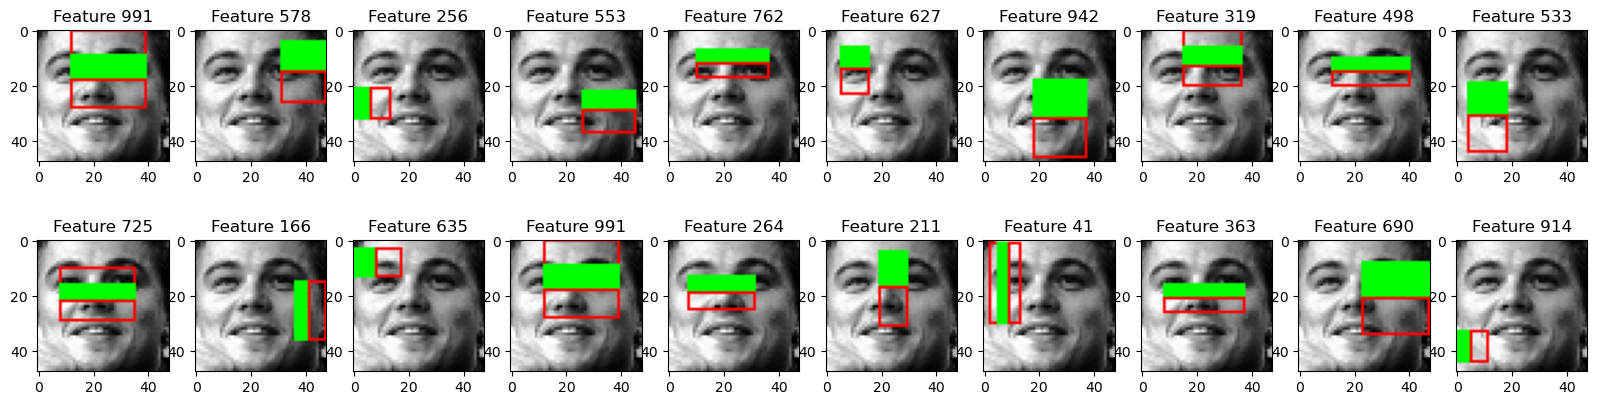

In [273]:
plt.figure(figsize=(20,5))
for i in range(20):
    haar_features_im = cv2.cvtColor(X_faces[14],cv2.COLOR_GRAY2RGB).copy()
    draw_haar_feature(haar_features_im, haar_features[bdt.estimators_[i].tree_.feature[0]])
    plt.subplot(2,10,i+1)
    plt.imshow(haar_features_im),plt.title("Feature %d"%(bdt.estimators_[i].tree_.feature[0]))

As you can see the selected features are quite indicative of whether there is a face in the image, mostly concerned with the eyes area.

We can also visualize how much classification error each weak estimator has:

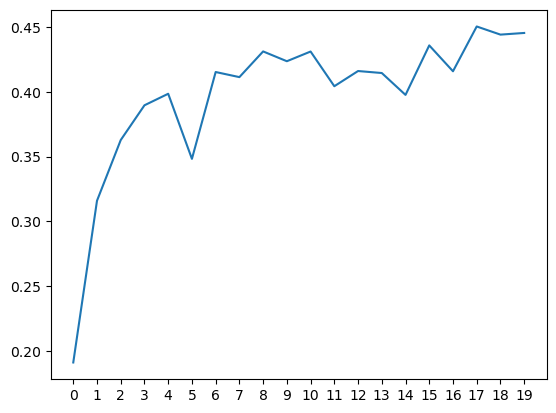

In [274]:
plt.plot(bdt.estimator_errors_),plt.xticks(range(20));

It's obvious that the first few features are the better ones with minimum error in classification, which is why they were selected first.

We can evaluate our classifier on the test set:

In [275]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = bdt.predict(X_test)
print("Accuracy:\t",  accuracy_score(y_test, y_pred))
print("Precision:\t", precision_score(y_test, y_pred))
print("Recall:\t\t",  recall_score(y_test, y_pred))
print("F1 score:\t",  f1_score(y_test, y_pred))

Accuracy:	 0.8895486935866983
Precision:	 0.8798543689320388
Recall:		 0.8928571428571429
F1 score:	 0.8863080684596577


The classifier gets a pretty high F1 score ($\sim$ 0.88), which means it is well balanced between precision and recall.

### Hyperparameter Tuning
Let's try to find the optimal number of estimators, since 20 is pretty arbitrary.

Using a "Grid Search" we can test different values of the parameter.

Use `sklearn.model_selection`'s `GridSearchCV` to test out value for `n_estimators` of the `AdaBoostClassifier`.
Try out the following values: 15, 20, 30, 50, 80

Read on how to do this at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [276]:
# grid_search = ...
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=bdt, param_grid={'n_estimators': [15, 20, 30, 50, 80]}, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                          n_estimators=20),
             param_grid={'n_estimators': [15, 20, 30, 50, 80]})

Which is the best model?

In [277]:
grid_search.best_estimator_.n_estimators

80

As expected the 80-features model is the best, with the highest accuracy. If we would have increased that number futher we would expect to see some overfitting.

In [278]:
y_pred = grid_search.best_estimator_.predict(X_test)
print("Accuracy:\t",  accuracy_score(y_test, y_pred))
print("Precision:\t", precision_score(y_test, y_pred))
print("Recall:\t\t",  recall_score(y_test, y_pred))
print("F1 score:\t",  f1_score(y_test, y_pred))

Accuracy:	 0.911520190023753
Precision:	 0.9077490774907749
Recall:		 0.9088669950738916
F1 score:	 0.9083076923076923


However, the added benefit of the 60 additional features (!!) over our 20-features model translates to just 0.02 increase in F1, which is neglegible. We can probably do just as well with the 15-features model as well, and gain a significant speed boost.

### Detect faces in an image

In [279]:
import PIL
import urllib.request

In [280]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/6/6e/Solvay_conference_1927.jpg/1024px-Solvay_conference_1927.jpg'
im = cv2.resize(np.array(PIL.Image.open(urllib.request.urlopen(url))), (0,0), fx=1.2, fy=1.2)

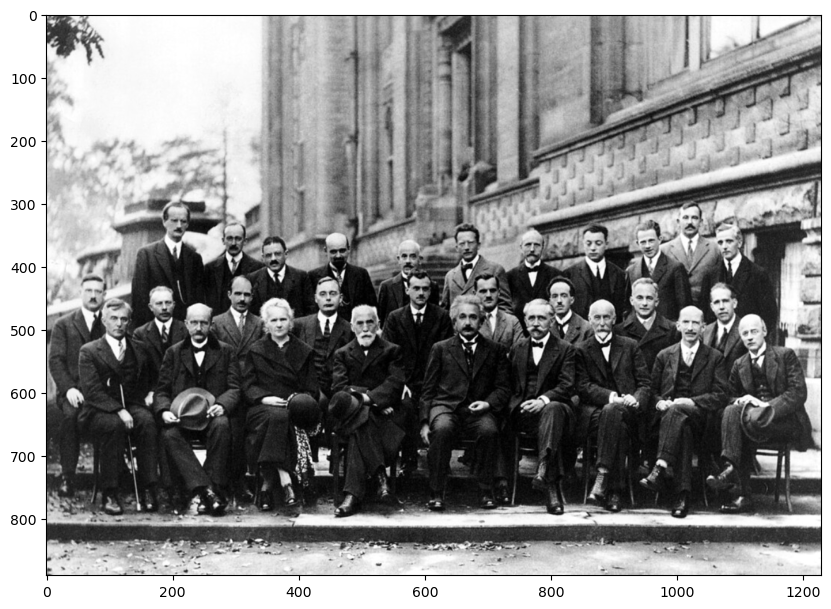

In [281]:
plt.figure(figsize=(10,10))
plt.imshow(im, cmap='gray');

This is the famous 1927 Solvay Conference picture that features some the finest phyicists of the time like Einstien, Bohr, Schrödinger, Dirac, Marie Curie, Planck, and others.

Now, instead of calculating all of the 1000 Haar-like features, we need only to calculate the ones selected by our 20-feature classifier. 

This will immensly increase the calculation time, having to evaluate the response for just 20 features instead of 1000.

In [282]:
X_faces_features = np.array(X_faces_features)

# this is the complete list of features
X_faces_features.shape

(8416, 1000)

In [283]:
# TODO: Gather just the 20 selected features indices in the original 1000-long vector
# and extract the feature responses from the X_faces_features tensor using these indices
# and store them in `X_faces_features_selected`.
# NOTE: they may not be unique, so you may need to remove duplicates with np.unique()
# also store the selected features "description" (x,y,w,h,type) in the `haar_features_selected` list
# taken from the original haar_features list.
haar_features_selected_index = [estimator.tree_.feature[0] for estimator in grid_search.best_estimator_.estimators_[:20]]

# Remove duplicates and keep the order
unique_haar_features_selected_index = np.unique(haar_features_selected_index, return_index=True)[1]
ordered_unique_indices = [haar_features_selected_index[index] for index in sorted(unique_haar_features_selected_index)]

# Extract the feature responses using the unique, ordered indices
X_faces_features_selected = X_faces_features[:, ordered_unique_indices]

# Get the selected features descriptions
haar_features_selected = [haar_features[i] for i in ordered_unique_indices]

In [284]:
# this is the reduced list of features, expected shape
X_faces_features_selected.shape

(8416, 19)

In [285]:
# split the data into train and test
X_train_select, X_test_select, y_train_select, y_test_select = train_test_split(X_faces_features_selected, y_faces, test_size=0.2, random_state=42)

In [286]:
# TODO: re-train the classifier on the selected features
bdt = AdaBoostClassifier(estimator=base_estimator, n_estimators=20)
bdt.fit(X_train_select, y_train_select)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=20)

In [287]:
y_pred = bdt.predict(X_test_select)
print("Accuracy:\t",  accuracy_score(y_test_select, y_pred))
print("Precision:\t", precision_score(y_test_select, y_pred))
print("Recall:\t\t",  recall_score(y_test_select, y_pred))
print("F1 score:\t",  f1_score(y_test_select, y_pred))

Accuracy:	 0.8842042755344418
Precision:	 0.8932038834951457
Recall:		 0.8730723606168446
F1 score:	 0.8830233953209359


In [288]:
# detect faces in the image `im` using the selected features
# equalize histogram, compute integral image, and loop over the image with a sliding window
# of size 50x50 with a stride of 10 pixels. for each window, crop the integral image to 50x50.
# extract the features responses for the selected features using the 
# `extract_haar_features_responses` function (which expects input of size 50x50).
# and use the classifier to predict the face/non-face class. use `.predict_proba` 
# and a threshold (I used 0.5) to determine if a positive detection is made.
# store the detections in the `detections` list, each detection is a tuple (x,y,pred_prob)

im_eq = cv2.equalizeHist(im)

# Parameters for the sliding window
window_size = 50
stride = 10

# Detect faces
detections = []
for y in range(0, im_eq.shape[0] - window_size, stride):
    for x in range(0, im_eq.shape[1] - window_size, stride):
        # Crop the equalized image to a 50x50 window
        window = im_eq[y:y + window_size, x:x + window_size]

        # Extract the feature responses for the selected features
        features_responses = extract_haar_features_responses(window, haar_features_selected)

        # Predict face/non-face using the classifier
        pred_prob = bdt.predict_proba([features_responses])[0][1]  # Probability of the 'face' class

        # Check if the prediction is a face with a threshold of 0.5
        if pred_prob > 0.5:
            detections.append((x, y, pred_prob))



Visualizing the detections:

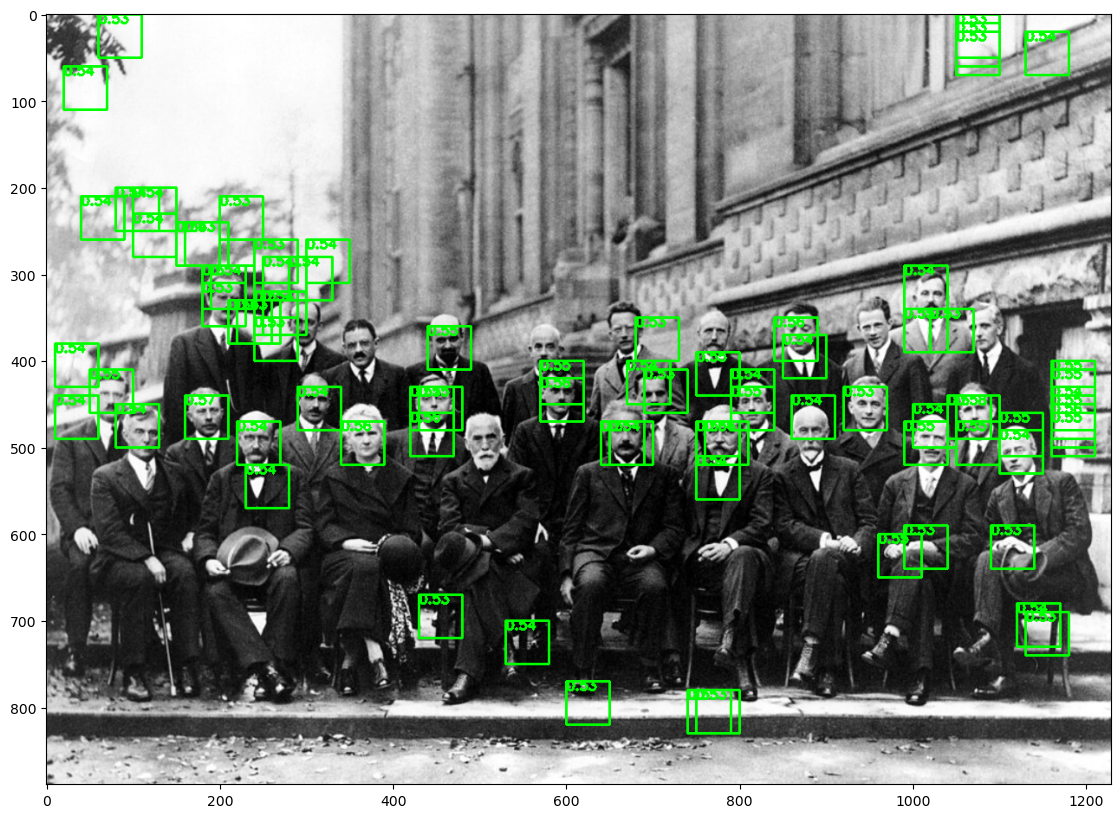

In [289]:
imdebug = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)
plt.figure(figsize=(20,10))
for x,y,pred in detections:
    if pred > 0.53:
        cv2.rectangle(imdebug, (x,y), (x+50,y+50), (0,255,0), 2)
        cv2.putText(imdebug, "%.2f"%pred, (x,y+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
plt.imshow(imdebug);

How about that for a face detector? Based on just 20 binary features, it's pretty nifty...

The actual method further speeds thing up by running each weak estimator in order and breaking early if chances are low to get a positive prediction.

## Object detection with Single Stage Detector
We will now implement a very simple region-proposal network (RPN) for just two classes (cats and dogs), which follows the Fast R-CNN scheme [[Ren 2015](https://proceedings.neurips.cc/paper/2015/file/14bfa6bb14875e45bba028a21ed38046-Paper.pdf)].

As a backbone we will use MobileNetV2 [[Sandler 2018](https://arxiv.org/abs/1801.04381)], which is a highly efficient conv net geared at realtime applications on mobile devices. It's very small, just a couple million of parameters, which lets it run very fast on modest hardware.

#### Download dataset

I've prepared a dataset of cats and dogs with bounding box annotation.

In [2]:
id = '1H5d-9C0u_nQd3HjKgdi9DqHBeg0bYuL_'
dl_url = f'https://drive.google.com/uc?id={id}&export=download&confirm=t'

if not os.path.exists('catsdogs_detection/2008_000019.jpg'):
    # download and show progress bar
    print('Downloading data.zip...')
    with open('data.zip', 'wb') as f:
        request = requests.get(dl_url, stream=True)
        total_length = int(request.headers.get('content-length'))
        for chunk in tqdm.tqdm(request.iter_content(chunk_size=1024), total=total_length/1024, unit='KB'):
            if chunk:
                f.write(chunk)
                f.flush()

    # extract zip file and show progress bar
    print('Extracting data.zip...')
    with zipfile.ZipFile('data.zip', 'r') as zip_ref:
        for file in tqdm.tqdm(zip_ref.namelist(), total=len(zip_ref.namelist())):
            zip_ref.extract(file)

    # remove the zip file
    os.remove('data.zip')

### Preparing the data for learning
This is a helper function we will need:

In [3]:
def batch_iou(a, b, epsilon=1e-5, show_debug=False):
    """ Given two arrays `a` and `b` where each row contains a bounding
        box defined as a list of four numbers: [x1,y1,x2,y2]
        Returns the Intersect of Union scores for each corresponding
        pair of boxes.

        A-----B             L------M
        |     |             |      |
        |   C-D----E      N-P----Q |
        |   | |    |      | |    | |
        F---G-H    I      R S----T-U
            |      |      |      |
            J------K      V------W
    """
    # a and b are arrays of shape (N,4)
    # returns an array of shape (N,)
    
    assert(a.shape[0] == b.shape[0])
    assert(a.shape[1] == 4)
    assert(b.shape[1] == 4)

    # calculate the (x, y)-coordinates of the intersection rectangle
    xA = np.maximum(a[:, 0], b[:, 0])
    yA = np.maximum(a[:, 1], b[:, 1])
    xB = np.minimum(a[:, 2], b[:, 2])
    yB = np.minimum(a[:, 3], b[:, 3])

    # compute the area of intersection rectangle
    interArea = np.maximum(0, xB - xA + 1) * np.maximum(0, yB - yA + 1)
    unionArea = (a[:, 2] - a[:, 0] + 1) * (a[:, 3] - a[:, 1] + 1) + (b[:, 2] - b[:, 0] + 1) * (b[:, 3] - b[:, 1] + 1) - interArea
    iou = interArea / (unionArea + epsilon)

    if show_debug:
        # plot the rectangles
        fig, ax = plt.subplots(1)
        ax.imshow(np.zeros((224,224,3)))
        for i,rect in enumerate(a):
            if iou[i] > 0.6:
                patch = patches.Rectangle((rect[0],rect[1]),rect[2]-rect[0],rect[3]-rect[1],linewidth=1,edgecolor='r',facecolor='none')
                ax.add_patch(patch)
                ax.text(rect[0],rect[1],iou[i],color='r')
        for i,rect in enumerate(b):
            if iou[i] > 0.6:
                patch = patches.Rectangle((rect[0],rect[1]),rect[2]-rect[0],rect[3]-rect[1],linewidth=1,edgecolor='b',facecolor='none')
                ax.add_patch(patch)
                ax.text(rect[0],rect[1],iou[i],color='r')
        plt.show()

    return iou

#### Grid
We will be working in a $7\times 7$ grid to match our MobileNetV2 model that ended with a $7\times 7 \times 1280$ tensor of visual features.

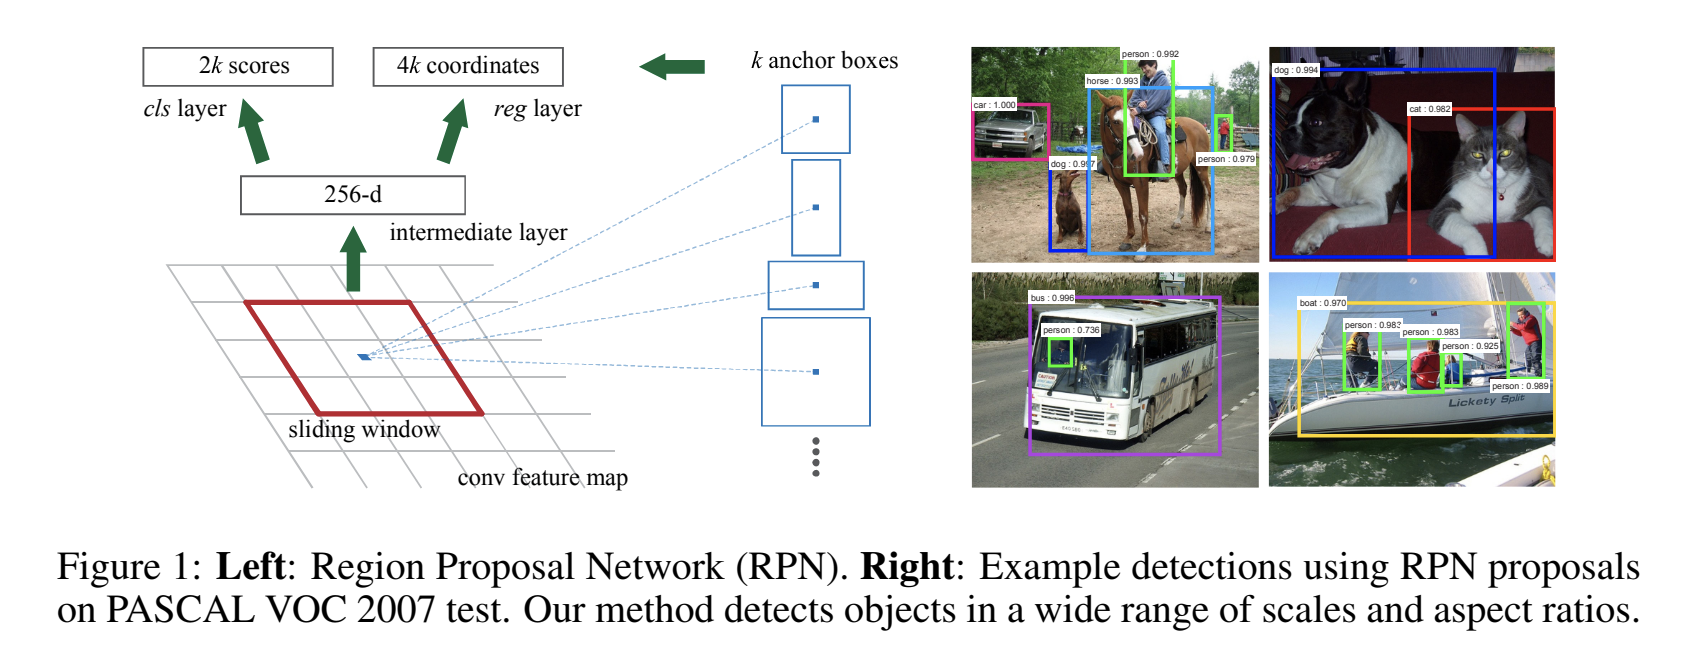

In YOLO, SSD and Fast RCNN there's a choice of box aspects in each grid cell, e.g. $1:1$, $1:2$, $2:1$, ..., however we will use a simpler approach of only $1:1$ aspect boxes of different sizes.

We construct a grid of bounding boxes $3\times 3$, $4\times 4$, $5\times 5$, $6\times 6$ and $7\times 7$ size in sliding window style, like the figure above taken from the Fast RCNN paper.

In [4]:
# 7x7 points evenly spaced in the 0,0->224,224 range. 
# e.g. 0,0 0,32 0,64 0,96 0,128 0,160 0,192 0,224, ...
bb_points_grid = np.dstack(np.meshgrid(np.linspace(0,224,8), np.linspace(0,224,8)))

bb_box_grid = []
for r in range(2,6): # size of the box (3x3, 4x4, 5x5, 6x6)
    for i in range(r): # horizontal shift (e.g. 6x6 has 0,1, 5x5 has 0,1,2, 4x4 has 0,1,2,3, etc.)
        for j in range(r): # vertical shift
            top_left = bb_points_grid[i,j]
            bottom_right = bb_points_grid[i+(8-r),j+(8-r)]
            bb_box_grid.append(np.hstack([top_left,bottom_right]))

# add the 7x7 box (whole image)
bb_box_grid.append(np.hstack([bb_points_grid[0,0],bb_points_grid[-1,-1]]))

I'll do my best to visualize all the bounding boxes for you here, but keep in mind they are all overlapping! so it'd be hard to see each one.

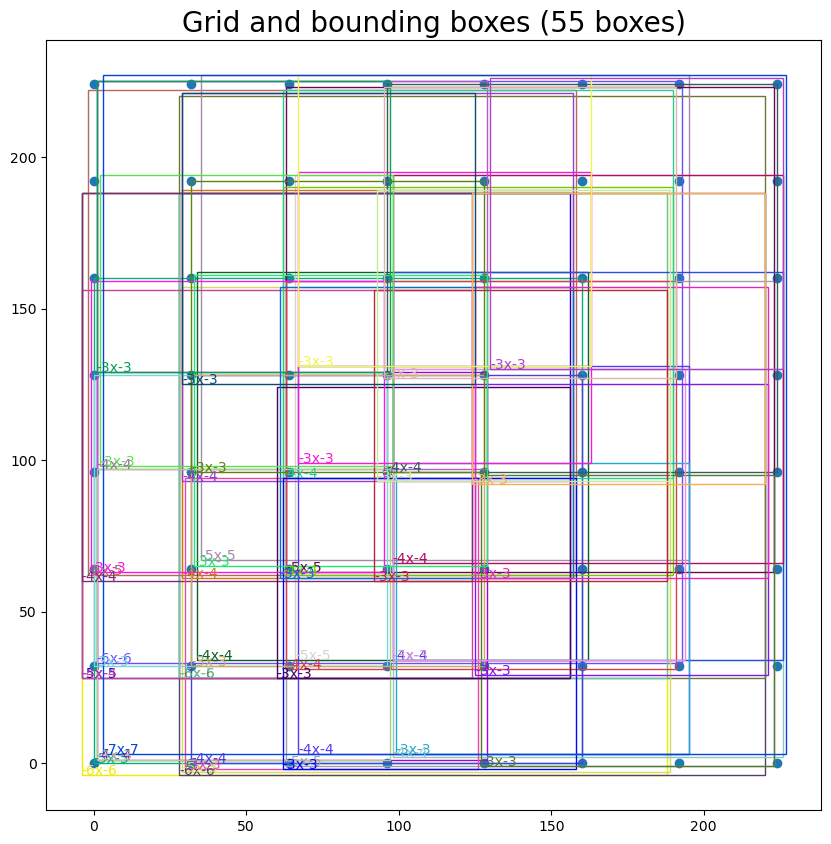

In [5]:
from matplotlib import patches

plt.figure(figsize=(10,10))
plt.scatter(bb_points_grid.reshape(-1,2)[:,0], bb_points_grid.reshape(-1,2)[:,1])
ax = plt.gca()
for i,bb in enumerate(bb_box_grid):
    r = np.random.randint(-4,4)
    c = np.hstack([np.random.random(3),1])
    rect = patches.Rectangle((bb[0]+r,bb[1]+r),bb[2]-bb[0],bb[3]-bb[1],edgecolor=c,facecolor='none')
    ax.add_patch(rect)
    grid_bb = np.int32(bb_box_grid[i] * 7 / 224)
    ax.text(bb[0]+r,bb[1]+r,f"{grid_bb[0]-grid_bb[2]}x{grid_bb[1]-grid_bb[3]}",color=c)
plt.title(f"Grid and bounding boxes ({len(bb_box_grid)} boxes)", fontsize=20);

#### Reading the data
The dataset is a group of images with associated JSON files with the bounding box + class annotation.

We must rescale the images to $224\times 224$ like the input to our classification net, with the same resize-with-pad trick so not to harm the aspect ratio of objects.

Thereafter we transform the bounding boxes with the same scaling and (possible) translation on either x- or y-axis.

We match the bounding boxes with each BBox in the grid, and if there's a match (high IoU) we find the offset (e.g. residual) from the grid-BBox to the true BBox, which is what we would like to find. We also note that grid-BBox has an object in it and which class it is.

I'm providing this code since it's following the structure of the dataset I created. Review it and see that you roughly understand what it does.

In [6]:
def make_detection_dataset_for_directory(directory, batch_size, shuffle=True, take_subset=-1, print_debug=False):
    images = sorted(glob.glob('%s/*.jpg'%directory))
    jsons  = sorted(glob.glob('%s/*.json'%directory))
    assert(len(images) == len(jsons))
    if take_subset < 0:
        take_subset = len(jsons)
    print("Found %d images in '%s'"%(len(images), directory))

    if take_subset != len(jsons):
        print(f"Taking a subset of {take_subset} images")
        images = images[:take_subset]
        jsons = jsons[:take_subset]
    
    labels = []
    for i,(json_file, image_file) in enumerate(zip(jsons,images)):
        with Image.open(image_file) as img:
            width, height = img.size

        scale = np.max([width,height]) / 224.
        pad_x = (224. - width / scale) / 2.
        pad_y = (224. - height / scale) / 2.

        if print_debug:
            print(f"Processing {json_file}...")
            print(f"  Image size: {width}x{height}")
            print(f"  Scale: {scale}")
            print(f"  Padding: {pad_x},{pad_y}")

        y = [[0,0,0,0,0,0]] * len(bb_box_grid)
        with open(json_file, 'r') as f:
            for n,b in json.load(f):
                c = 1 if n == 'dog' else 0
                # transform BBox
                b_new = np.array(b) / scale + np.array([pad_x,pad_y,pad_x,pad_y])
                
                # match with BBox grid
                ious = batch_iou(np.int32(bb_box_grid), np.int32([b_new] * len(bb_box_grid)), print_debug)

                # find grid-BBox[s] that has high IoU
                found_idxs = np.squeeze(np.argwhere(ious > 0.55))
                if found_idxs.size == 1:
                    found_idxs = [found_idxs]

                if print_debug:
                    print(f'original box {b} transformed to {b_new}')
                    print(f'found {len(found_idxs)} grid boxes with IoU > 0.6')

                for found_idx in found_idxs:
                    # Set [box residual/offset (normalized [-1,1]), class, objectness] in that grid-BBox
                    y[found_idx] = np.hstack([(b_new - bb_box_grid[found_idx]) / 224., c, 1])
                
        labels.append(np.float32(y).ravel())

    labels = np.array(labels)
            
    # Reads an image from a file, decodes it into a dense tensor, and preprocesses it
    def decode_image_file(filename, y):
        image_string = tf.io.read_file(filename)
        image_decoded = tf.io.decode_jpeg(image_string)
        image_resized = tf.image.resize_with_pad(image_decoded, 224, 224)
        image_resized = tf.cast(image_resized, tf.float32)
        return tf.keras.applications.mobilenet_v2.preprocess_input(image_resized), y
    
    dataset = tf.data.Dataset.from_tensor_slices((tf.constant(images[:take_subset]), 
                                                  tf.constant(labels[:take_subset])))
    dataset = dataset.map(decode_image_file, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(jsons), seed=42)
        
    # Split training and validation: 90-10
    train_dataset = dataset.take(int(take_subset * 0.9))
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.repeat()
    
    val_dataset = dataset.skip(int(take_subset * 0.9))
    val_dataset = val_dataset.batch(1)
    val_dataset = val_dataset.repeat()
        
    return train_dataset, val_dataset

#### Visualize some inputs

First read the directory and prepare the `tf.Dataset`s

In [7]:
detection_ds_train, detection_ds_val = make_detection_dataset_for_directory('./catsdogs_detection/', 32)

Found 2884 images in './catsdogs_detection/'


2023-12-04 13:34:28.049197: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-04 13:34:28.049220: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-04 13:34:28.049225: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-04 13:34:28.049279: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-04 13:34:28.049297: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
# helper function to display bboxes in the [x1,y1,x2,y2,c,s] structure
def show_boxes_offsets(im, y_boxes, threshold=None, nms=False):
    ax = plt.gca()
    ax.imshow(im)
    for x in np.linspace(0,im.shape[1],8):
        ax.axvline(x,lw=0.5)
    for y in np.linspace(0,im.shape[0],8):
        ax.axhline(y,lw=0.5)
    y_boxes_rs = y_boxes.reshape(-1,len(bb_box_grid),6)

    valid_bbs = (bb_box_grid + y_boxes_rs[:,:,:4] * 224.)
    if threshold is None:
        threshold = 0

    mask = y_boxes_rs[0, :, 5] > threshold
    if np.any(mask):
        # select only valid boxes accorind to threshold and mask
        valid_bbs = valid_bbs[0][mask]
        y_boxes_rs = y_boxes_rs[0][mask]
        bb_box_grid_select = np.array(bb_box_grid)[mask]
    else:
        return
    
    if nms:
        # non-maximum suppression
        valid_bbs = np.average(valid_bbs, axis=0, weights=y_boxes_rs[:,-1]).reshape(1,-1)
        y_boxes_rs = np.median(y_boxes_rs, axis=0).reshape(1,-1)

    for i,b in enumerate(valid_bbs):
        a = y_boxes_rs[i,-1] if nms else 1
        rect = patches.Rectangle((b[0],b[1]),b[2]-b[0],b[3]-b[1],
                                linewidth=2,edgecolor='r',facecolor='none',alpha=a,linestyle='--')
        ax.add_patch(rect)
        ax.text(b[0],b[1], 'cat' if y_boxes_rs[i,-2] < 0.5 else 'dog', color='r', fontsize=20, alpha=a)

        if not nms:
            gb = bb_box_grid_select[i]
            rect = patches.Rectangle((gb[0],gb[1]),gb[2]-gb[0],gb[3]-gb[1],
                                    linewidth=2,edgecolor='g',facecolor='none',alpha=a,linestyle='--')
            ax.add_patch(rect)
        
    ax.set_xlim([0,224]),ax.set_ylim([224,0]);

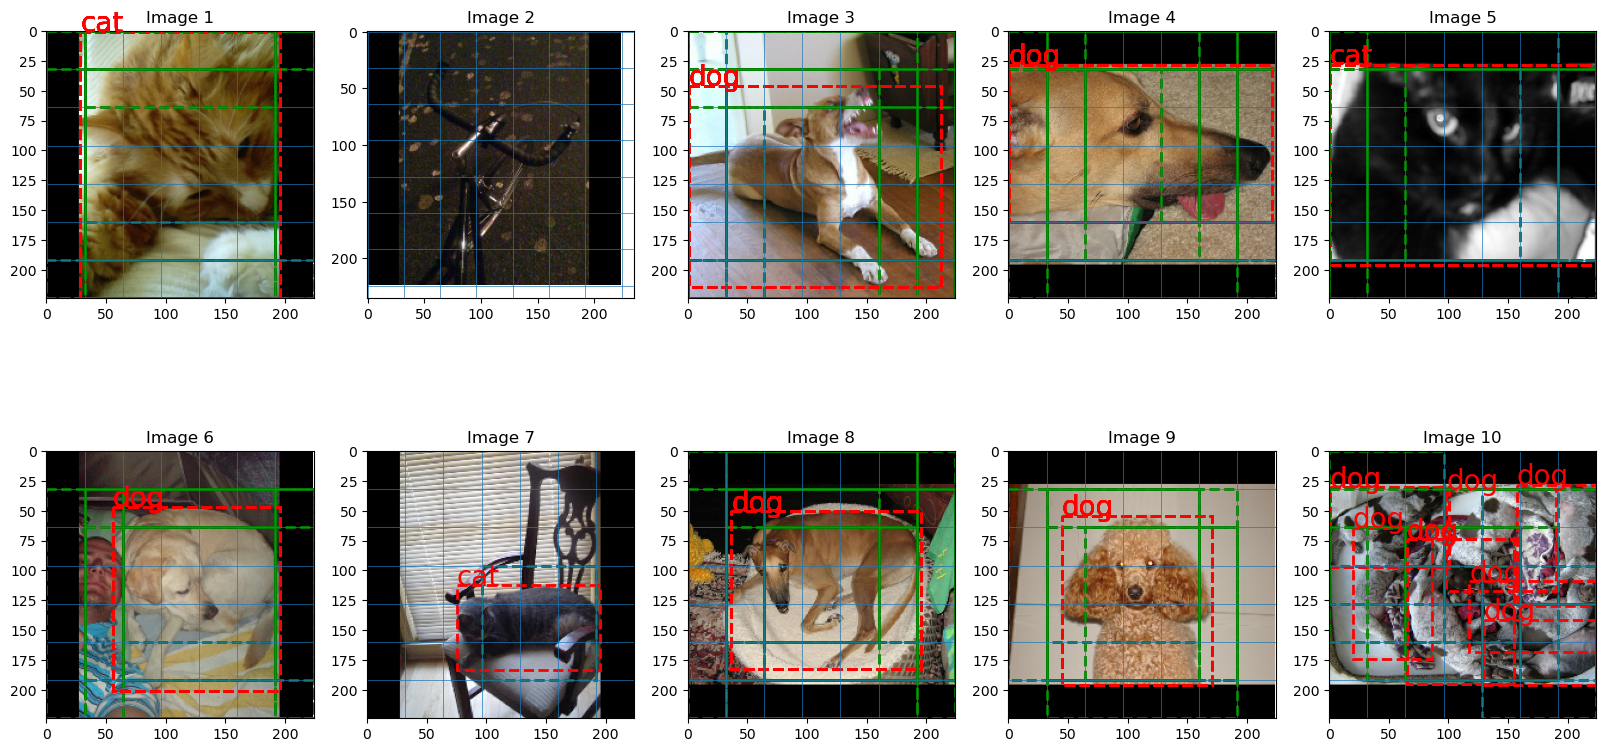

In [9]:
plt.figure(figsize=(20,10))
for i,(img,y) in enumerate(detection_ds_val.take(10)):
    plt.subplot(2,5,i+1)
    show_boxes_offsets(np.squeeze((img.numpy() + 1.0)/2.0), np.squeeze(y))
    plt.title(f"Image {i+1}")

### Transfer Learning, Detection model
We want to reuse the MobileNetV2 model that we get pre-trained for classification.

One way to do so is known as "Transfer Learning", which means we take a model trained on a different dataset for a different problem and transfer it to our problem.

Since the former model is already trained, we can "freeze" the layers already trained and only focus on any new layers we are going to add. This is easily done in Keras by `l.trainable = False` where `l` is a Keras layer.

To build our detection model, we take the classification model and snip off the head (classification parts, e.g. Dense, Flatten, etc.), and connect new layers that will do what we need according to our new problem.

Working with the bounding box grid we set up, we add for each of the 91 bounding boxes:
1. a Global Average Pooling to take the relevant slice of the 7x7 grid and pool the features to a fixed size.
1. A Dense layer to regress the BBox offset (4 output params with 'linear' activation)
1. A Dense layer to predict the class and "objectness" (2 output param with 'sigmoid' activation)

Finally we must `Concatenate()` all the outputs to a single output vector of 84 outputs. This vector we will meet again when we design the loss function.

In [187]:
# TODO: implement the function that builds the detection model
# get the MobileNetV2 model with imagenet weights and without the top layer (classification layer)
# set the model to be non-trainable (i.e. classification_model.trainable = False)
# set the input shape to (224,224,3). 
# set the include_top to False to remove the classification layer.
# Get the model from tf.keras.applications.MobileNetV2. Consult the documentation for more details.
# https://keras.io/api/applications/mobilenet/
# then for each grid box, create a layer that extracts features from the 7x7 features map
# at the grid box location. e.g. get the grid box location on the 7x7 feature map: np.int32(bb_box_grid[i] * 7 / 224)
# use `tf.slice` to slice the feature map at the grid box location, wrap with `tf.keras.layers.Lambda` to make it a layer.
# e.g. [0, grid_bb_x, grid_bb_y, 0], [0, grid_bb_h, grid_bb_w, 0] 
# where grid_bb_x, grid_bb_y, grid_bb_h, grid_bb_w are the grid box location on the 7x7 feature map.
# then use `tf.keras.layers.GlobalAveragePooling2D` to pool the features at the grid box location.
# the output of the pooling layer is the feature vector, it will have shape ([batch], 1280)
# now create two `tf.keras.layers.Dense`, one for the bounding box offset and one for the class prediction.
# the output of the bounding box offset layer should have shape ([batch], 4) with activation 'tanh'
# the output of the class-objectness prediction layer should have shape ([batch], 2) with activation 'sigmoid'
# then collect in a list the output of the two layers along with all the outputs from the other grid boxes.
# use tf.keras.layers.Concatenate to concatenate the outputs you get from the grid boxes, in the list above.

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Lambda, GlobalAveragePooling2D, Dense, Concatenate, Input
from tensorflow.keras.models import Model

def make_detection_model(trainable=False):
    # Load MobileNetV2 model without the top layer
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

    # Set the model to be non-trainable
    base_model.trainable = trainable

    # Initialize a list to collect outputs
    bbox_outputs = []
    class_outputs = []

    for i in range(len(bb_box_grid)):
    # Normalize box coordinates and convert to grid coordinates
        x1, y1, x2, y2 = bb_box_grid[i]
        grid_x1 = np.int32(x1 * 7 / 224)
        grid_y1 = np.int32(y1 * 7 / 224)
        grid_x2 = np.int32(x2 * 7 / 224)
        grid_y2 = np.int32(y2 * 7 / 224)

        # Calculate width and height
        grid_width = grid_x2 - grid_x1
        grid_height = grid_y2 - grid_y1

        # Slice the feature map
        sliced = Lambda(lambda x: tf.slice(x, [0, grid_x1, grid_y1, 0], [-1, grid_width, grid_height, -1]))(base_model.output)

        # Pool the features at the grid box location
        pooled = GlobalAveragePooling2D()(sliced)

        # Dense layer for bounding box offset
        bbox_output = Dense(4, activation='tanh')(pooled)

        # Dense layer for class and objectness prediction
        class_output = Dense(2, activation='sigmoid')(pooled)

        # Add the outputs to the list
        bbox_outputs.append(bbox_output)
        class_outputs.append(class_output)

    # Concatenate all outputs
    # outputs = Concatenate(axis=1)(outputs)
    # final_bbox_output = tf.keras.layers.Concatenate()(bbox_outputs)
    # final_class_output = tf.keras.layers.Concatenate()(class_outputs)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=[tf.stack(bbox_outputs,axis=1), tf.stack(class_outputs,axis=1)])

    return model

In [188]:
detection_model = make_detection_model()

In [189]:
test_input = np.random.random((32, 224, 224, 3))

y_pred_bbox,y_pred_class = detection_model.predict(test_input )

y_pred_bbox.shape, y_pred_class.shape

1/1 [==============================] - 2s 2s/step


((32, 55, 4), (32, 55, 2))

In [190]:
detection_model.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_45 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_45[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']     

You may want to inspect the model's architecture with `detection_model.summary()`.

One thing to notice is the number of weights for training. More weights, i.e. a bigger network, are harder to traing while controlling overfitting. 

#### Custom Multi-task Loss Function
We are trying to detect and classify at once, these are different tasks.

By detection we mean "regression of bounding box" (offset from "anchor") and that calls for a 
regression loss e.g. MSE. 
However the Fast and Faster-RCNN papers propose the "Smooth L1" which is devised like so:

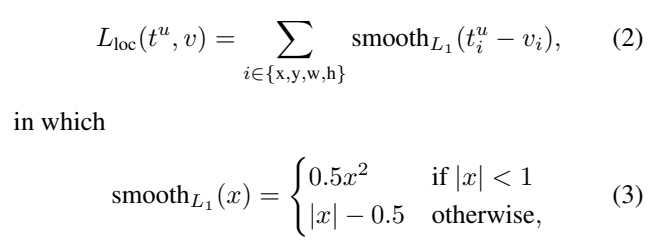

The smooth L1 loss makes it easy to handle outliers as well as keep the regression bounded.

For classification we usually use some cross entropy loss, e.g. the binary cross entropy or softmax.

A "multi-task loss" is a loss function that mixes a few problems together.

Remember our output is $330=55\times 6$ numbers: [x1_offset, y1_offset, x2_offset, y2_offset, class, is_object] for each bounding box.

In [244]:
bb_ct = len(bb_box_grid)



# write the custom loss function for the bounding box offset
# extract the bbox offset (4 numbers: x1,y1,x2,y2) from the y_true output (6 numbers)
# NOTE: the `y_true` will have shape of (<batch> or -1, bb_ct, 6), 
#       and y_pred will have shape (<batch> or -1, bb_ct, 4) (!!)
# implement the smooth L1 loss function as described above. use tf.abs and tf.square, and tf.where
# finally use tf.reduce_sum to get the summed loss for each sample in the batch.
# NOTE: only calculate the loss for samples that actually have an object in the grid box
# i.e. the class-objectness is 1.
# if you reshaped y_true_reshaped to have shape (<batch> or -1, bb_ct, 6), then the last number 
# is easily accessible with y_true_reshaped[:,:,5] - use that to create the mask
# then use tf.multiply to multiply the mask with the summed loss for each sample in the batch.
def bbox_loss(y_true, y_pred):
    y_true = tf.reshape(y_true,(-1, bb_ct, 6))
    # Extracting the bounding box offsets from y_true
    y_true_bbox = y_true[:, :, :4]

    # Calculate the difference
    diff = y_true_bbox - y_pred

    # Implementing Smooth L1 loss
    abs_diff = tf.abs(diff)
    squared_diff = tf.square(diff)
    l1_loss = tf.where(abs_diff < 1, 0.5 * squared_diff, abs_diff - 0.5)

    # Summing over the bounding box dimensions (i.e., x1, y1, x2, y2)
    sum_l1_loss = tf.reduce_sum(l1_loss, axis=-1)

    # Create a mask where objectness score is 1
    objectness_mask = tf.cast(y_true[:, :, 5] == 1, tf.float32)

    # Apply the mask
    masked_loss = tf.multiply(sum_l1_loss, objectness_mask)

    # Summing the loss over all samples in the batch
    final_loss = tf.reduce_sum(masked_loss)

    return final_loss


# write the custom loss function for the class-objectness prediction
# extract the class-objectness (2 numbers) from the 6-numbers output
# NOTE: the `y_true` will have shape of (<batch> or -1, bb_ct, 6), 
#       and y_pred will have shape (<batch> or -1, bb_ct, 2) (!!)
# same as above for the mask, you will need to use tf.where to mask the y_true and y_pred
# however in this case we do want to calculate the loss for the grid boxes that don't have an object
# so we don't apply the mask for the xentropy loss of the last number in the 6-numbers output.
# finally use tf.keras.losses.binary_crossentropy, however for the class prediction
# make sure to use tf.where to mask NaN values when the objectness is 0.
# this can be done by using tf.math.is_nan to create a mask of NaN values, and then use tf.where
# to replace the NaN values with 0 (e.g. tf.zeros_like)
def class_loss(y_true, y_pred):
    y_true = tf.reshape(y_true,(-1, bb_ct, 6))
    y_true_class = y_true[:, :, 4:6]  # Extract the class and objectness scores
    objectness_mask = tf.expand_dims(y_true[:, :, 5], -1)  # Mask for objectness
    y_pred_masked = tf.where(tf.math.is_nan(y_pred), tf.zeros_like(y_pred), y_pred)
    y_true_masked = tf.where(tf.math.is_nan(y_true_class), tf.zeros_like(y_true_class), y_true_class)

    # Binary cross-entropy loss
    bce_loss = tf.keras.losses.binary_crossentropy(y_true_masked, y_pred_masked, from_logits=False)
    # Squeeze the objectness_mask to match the shape of bce_loss
    objectness_mask_squeezed = tf.squeeze(objectness_mask, axis=-1)

    # Apply the squeezed mask
    bce_loss_masked = tf.multiply(bce_loss, objectness_mask_squeezed)

    return tf.reduce_mean(bce_loss_masked)  # Average over all samples in the batch



Note that YOLO [[Redmon 2016]](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Redmon_You_Only_Look_CVPR_2016_paper.pdf) is using a slightly different loss. They have SSD (sum of squared differences) on the top-left X, Y of the rectangle and SSD of the square roots of the W, H of the rectangle, e.g. 
$$
\displaystyle\left(\sqrt{W_\mathrm{True}}-\sqrt{W_\mathrm{Pred}}\right)^2+\left(\sqrt{H_\mathrm{True}}-\sqrt{H_\mathrm{Pred}}\right)^2
$$
Also, surprisingly they are not using a binary cross-entropy for the class score or the objectness probability, instead they are again using SSD with complement for punishing False-Positives: $\mathcal{1}_{\mathrm{obj}}\left(C_\mathrm{True}-C_\mathrm{Pred}\right)^2+\mathcal{1}_{\mathrm{not\_obj}}\left(C_\mathrm{True}-C_\mathrm{Pred}\right)^2$

You're welcome to try this scheme, at least for the bounding box. It should be very simple to implement the width root (e.g. `w = K.square(x2-x1)`) and then use it in the `tf.keras.losses.mean_squared_error`.

In [245]:
detection_model.compile(optimizer='adam', loss=[bbox_loss, class_loss], run_eagerly=True)

In [246]:
# keep track of the best weights
checkpoint = tf.keras.callbacks.ModelCheckpoint('cats_dogs_detection.best_weights.hdf5', 
                                                monitor='val_loss', 
                                                verbose=0, 
                                                save_best_only=True, 
                                                save_weights_only=True, 
                                                mode='auto')

In [252]:
detection_model.fit(detection_ds_train,
                    epochs=20,
                    steps_per_epoch=2500//32,
                    validation_data=detection_ds_val,
                    validation_steps=50,
                    callbacks=[checkpoint]
                    )

Epoch 1/20


78/78 [==============================] - 60s 748ms/step - loss: 13.6629 - tf.stack_8_loss: 13.6625 - tf.stack_9_loss: 4.3453e-04 - val_loss: 0.5324 - val_tf.stack_8_loss: 0.5321 - val_tf.stack_9_loss: 2.4882e-04
Epoch 2/20
78/78 [==============================] - 58s 740ms/step - loss: 13.9748 - tf.stack_8_loss: 13.9744 - tf.stack_9_loss: 3.7404e-04 - val_loss: 0.4326 - val_tf.stack_8_loss: 0.4321 - val_tf.stack_9_loss: 5.2847e-04
Epoch 3/20
78/78 [==============================] - 57s 726ms/step - loss: 13.5525 - tf.stack_8_loss: 13.5521 - tf.stack_9_loss: 3.6998e-04 - val_loss: 0.4801 - val_tf.stack_8_loss: 0.4793 - val_tf.stack_9_loss: 7.8995e-04
Epoch 4/20
78/78 [==============================] - 57s 726ms/step - loss: 13.0344 - tf.stack_8_loss: 13.0340 - tf.stack_9_loss: 3.5647e-04 - val_loss: 0.5809 - val_tf.stack_8_loss: 0.5807 - val_tf.stack_9_loss: 2.8241e-04
Epoch 5/20
78/78 [==============================] - 57s 735ms/step - loss: 12.6417 - tf.stack_8_loss: 12.6414 - tf.stac

### Qualitatively evaluate the model

In [253]:
detection_model.load_weights('cats_dogs_detection.best_weights.hdf5')

1/1 [==============================] - 0s 168ms/step


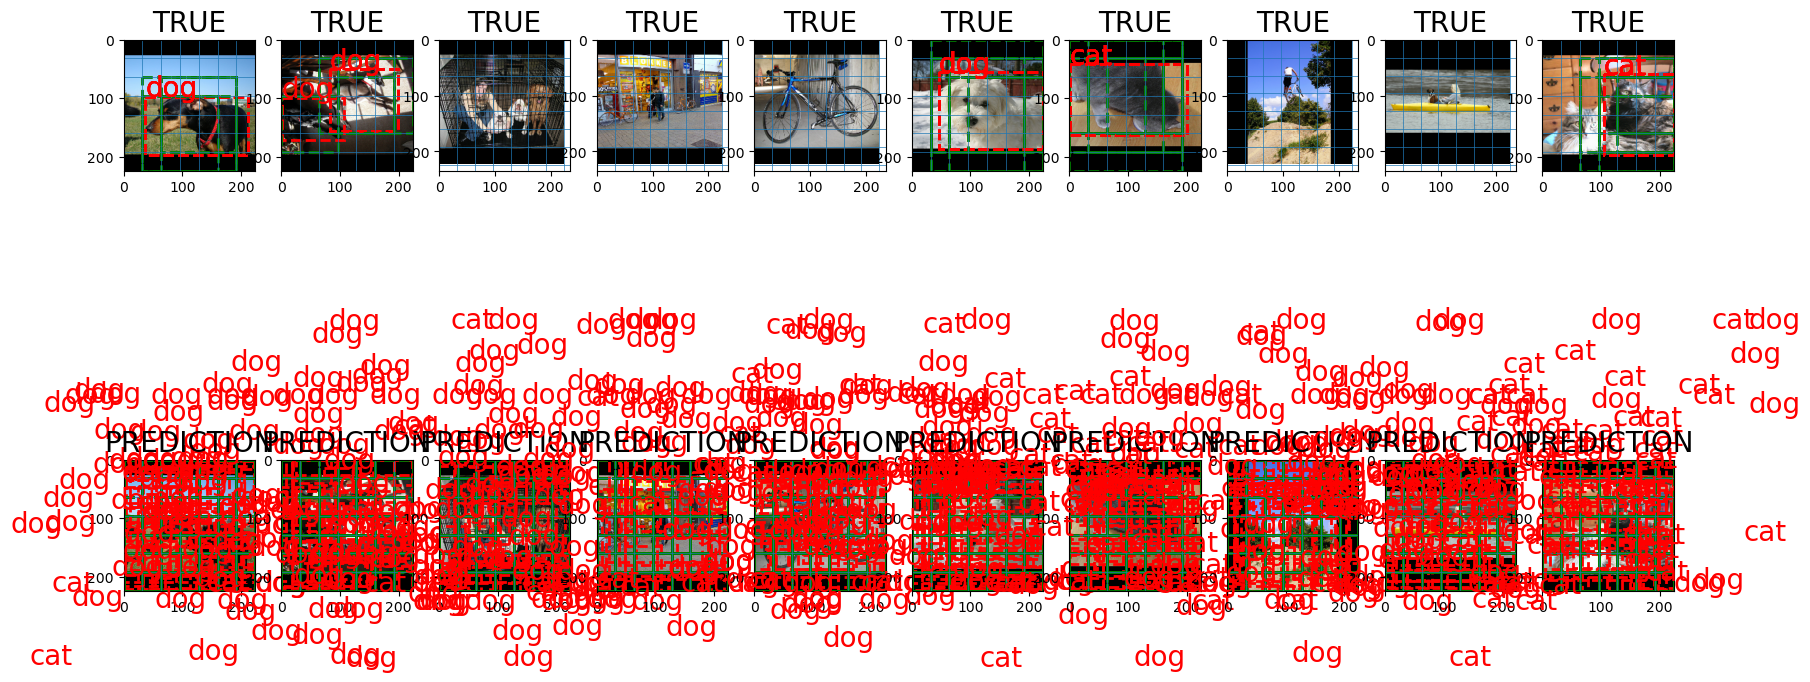

In [254]:
plt.figure(figsize=(20,10))
for i,(img,y) in enumerate(detection_ds_val.take(10)):
    plt.subplot(2,10,i+1)
    plt.title('TRUE', fontsize=20)
    show_boxes_offsets(np.squeeze((img + 1.0)/2), np.squeeze(y))

    y_pred_bbox,y_pred_class = detection_model.predict(img)
    plt.subplot(2,10,i+11)
    plt.title('PREDICTION', fontsize=20)
    show_boxes_offsets(np.squeeze((img + 1.0)/2), np.dstack([y_pred_bbox.reshape(-1,55,4), y_pred_class.reshape(-1,55,2)]).reshape(1,-1),0.5)

Neat! You created a single stage object detector!

Granted, your model can only find cats and dogs, and is restricted to just $1:1$ anchor BBoxes (with added regression to predict the true box).

Still - I'd say this is a pretty cool thing you made.

We have a lot of boxes in the image, but we can see that the model is able to detect the objects and classify them.
Let's clean up the boxes a bit and see what we get by applying "non-maximum suppression".

1/1 [==============================] - 0s 167ms/step


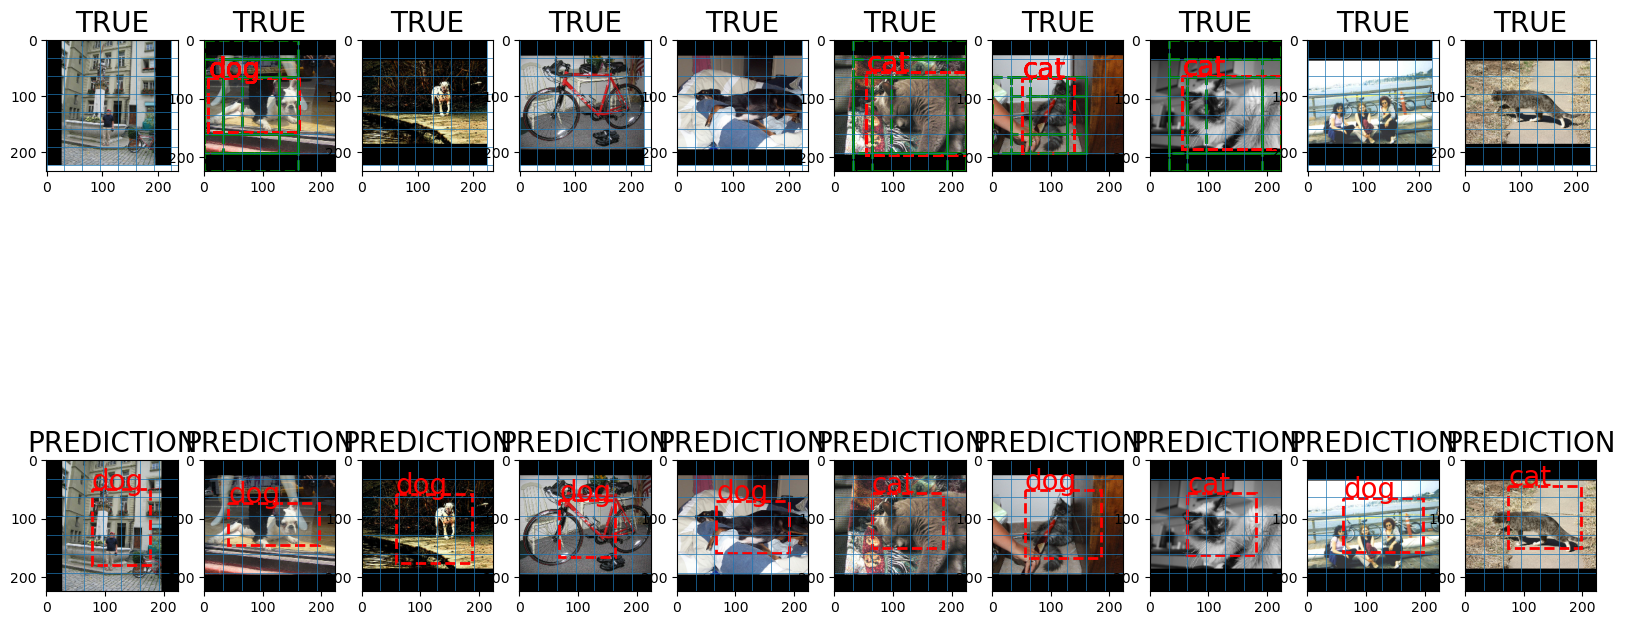

In [259]:
plt.figure(figsize=(20,10))
for i,(img,y) in enumerate(detection_ds_val.take(10)):
    plt.subplot(2,10,i+1)
    plt.title('TRUE', fontsize=20)
    show_boxes_offsets(np.squeeze((img + 1.0)/2), np.squeeze(y))

    y_pred_bbox,y_pred_class = detection_model.predict(img)
    plt.subplot(2,10,i+11)
    plt.title('PREDICTION', fontsize=20)
    combined = np.dstack([y_pred_bbox.reshape(-1,len(bb_box_grid),4), y_pred_class.reshape(-1,len(bb_box_grid),2)]).reshape(1,-1)
    show_boxes_offsets(np.squeeze((img + 1.0)/2), combined, 0.5, nms=True)

Does it look close to the ground truth?

That's a wrap!